<a href="https://colab.research.google.com/github/kiplimock/colab-notebooks/blob/main/segment_anything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If the following packages are not installed, uncomment the code in the following cell and run the installations.

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_rl5c8l8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_rl5c8l8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=9cdd8bbaf279f4e2721a71442b12b110e0b90f903726aa18d1dba40d2cedb057
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6rw5m6f/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
using_colab = True

In [4]:
if using_colab:
    import os
    import torch
    import torchvision

    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    if not os.path.exists("/content/images"):
      !mkdir images
      !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
      !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
      !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    if not os.path.exists('sam_vit_h_4b8939.pth'):
      !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-eexrobbi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-eexrobbi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-01-25 07:34:34--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  --

In [51]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('..')
import segment_anything as sa
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
def show_anns(anns):
  if len(anns) == 0:
    return

  # sort masks according to area of region
  ax = plt.gca()
  ax.set_autoscale_on(False)

  # create a 4-channel (RGBA) image of the same H and W as the mask, set the last channel to 0
  img = np.ones((anns['segmentation'].shape[0], anns['segmentation'].shape[1], 4))
  img[:,:,3] = 0

  # set the color for each segment/region to a random color with opacity of 0.35
  # for ann in anns:
  m = anns['segmentation']
  color_mask = np.concatenate([np.random.random(3), [0.35]])
  img[m] = color_mask

  # display the annotated image
  ax.imshow(img)

In [7]:
model_path = "sam_vit_h_4b8939.pth"

## Example Image

In [9]:
image = cv2.imread("/content/images/dog.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

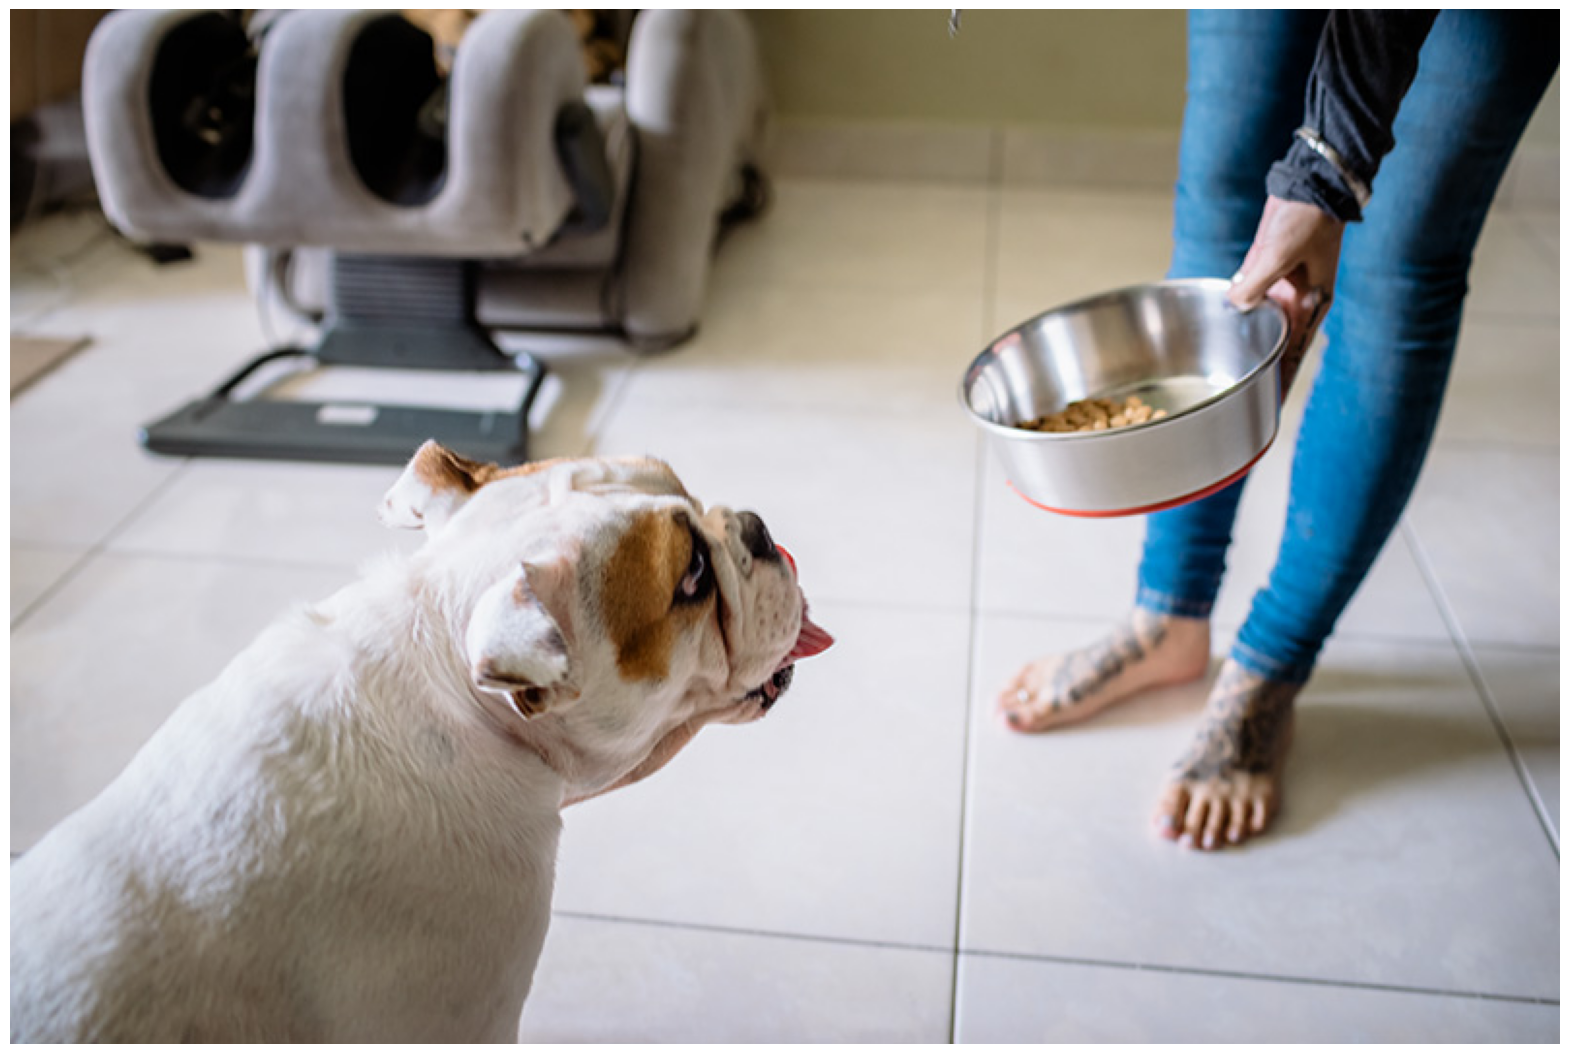

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### Automatic Mask Generation

In [11]:
def generate_masks(image):
  '''
  Generates the masks of the image
  '''

  sam_checkpoint = model_path
  model_type = "vit_h"

  device = "cuda" if torch.cuda.is_available() else "cpu"
  sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
  sam.to(device=device)

  mask_generator = SamAutomaticMaskGenerator(
      model=sam,
      points_per_side=32,
      pred_iou_thresh=0.92,
      stability_score_thresh=0.92,
      crop_n_layers=1,
      crop_n_points_downscale_factor=2,
      min_mask_region_area=100
  )

  masks = mask_generator.generate(image)
  masks = sorted(masks, key=lambda x: x['area'], reverse=True)[:5]

  h, w, _ = image.shape
  num = int(0.17 * h * w)
  mask_index = np.argmin([abs(mask['area'] - num) for mask in masks])
  mask_index

  return masks[mask_index]

In [12]:
masks = generate_masks(image)

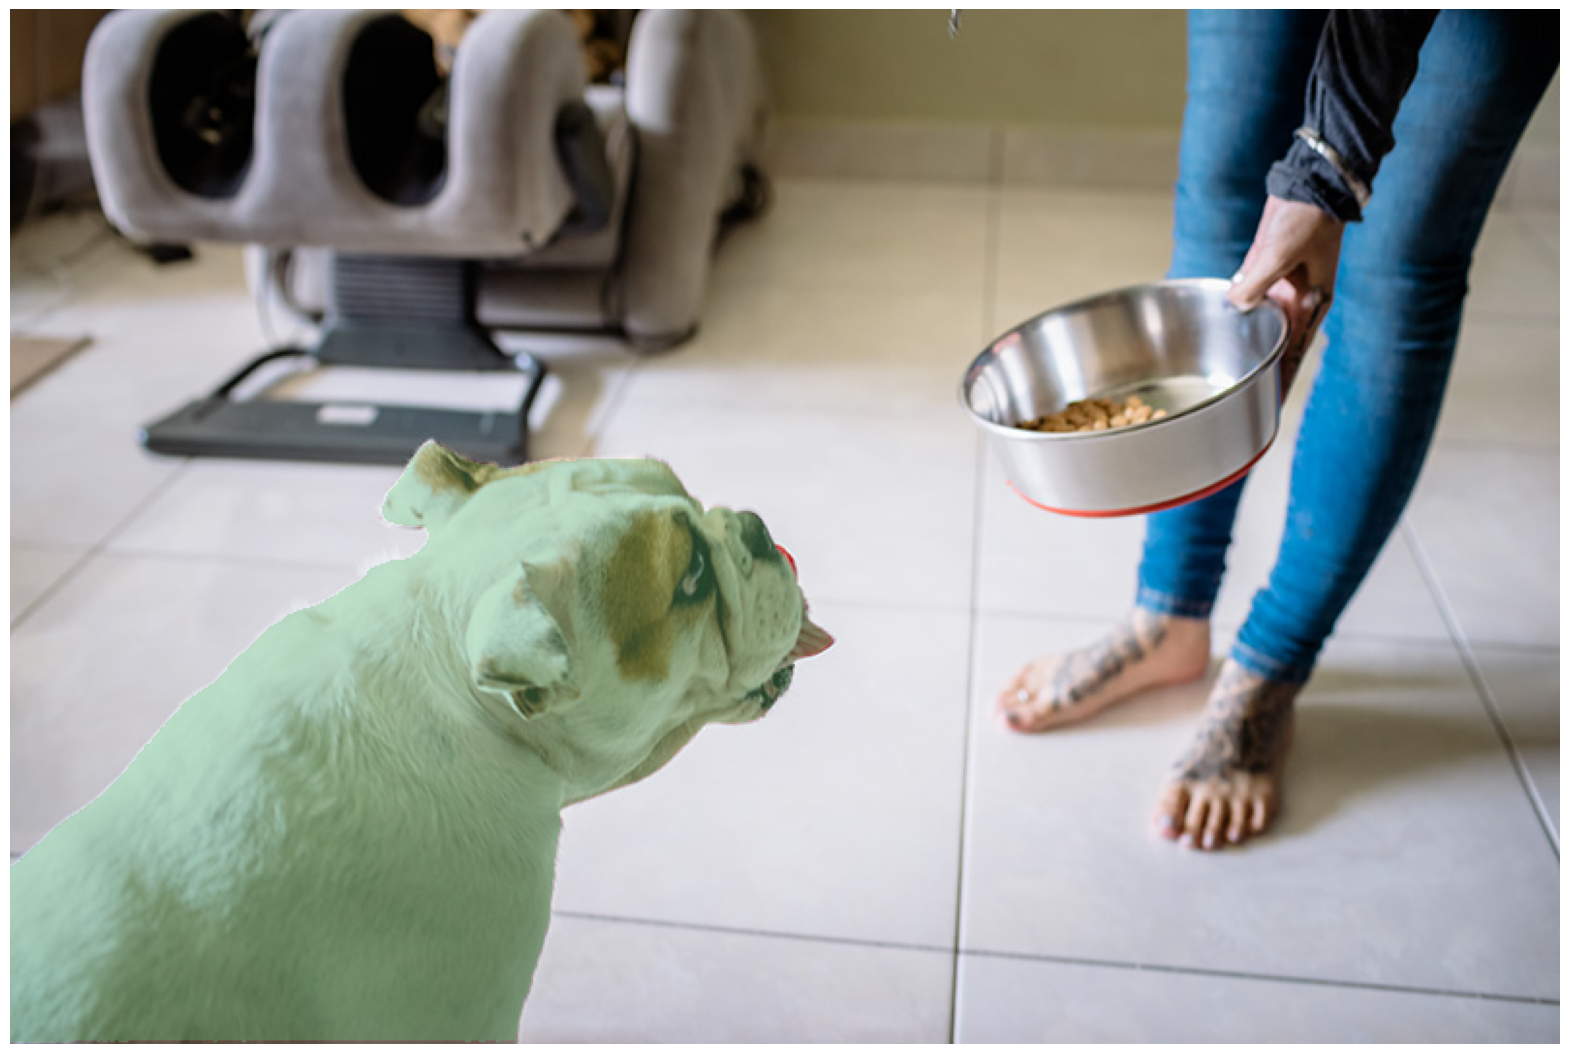

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Using the SAM Predictor
### 1. Selecting Objects with SAM

In [33]:
def show_mask(mask, ax, random_color=False):
  # create an array for RGBA colour
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])

  # overlay mask region with the RGBA colour
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1] # coordinates of points in the foreground
  neg_points = coords[labels==0] # coordinates of points in the background

  # show location of points on a scatter plot
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
  # plot the bounding box on the image axis
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [47]:
def create_predictor(image):
  '''
  Predict an image mask using the SAM predictor object
  '''
  sam_checkpoint = model_path
  model_type = "vit_h"

  device = "cuda" if torch.cuda.is_available() else "cpu"

  sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
  sam.to(device=device)

  predictor = SamPredictor(sam)
  predictor.set_image(image)

  return predictor

In [53]:
truck = cv2.imread('images/truck.jpg')
truck = cv2.cvtColor(truck, cv2.COLOR_BGR2RGB)
predictor = create_predictor(truck)

In [64]:
input_point = np.array([[500, 375]]) # , [1125, 625]
input_label = np.array([1])

In [61]:
def predict_mask(predictor: sa.predictor.SamPredictor):

  masks, scores, logits = predictor.predict(
      point_coords = input_point,
      point_labels = input_label,
      multimask_output=True
  )

  return masks, scores, logits

In [65]:
masks, scores, logits = predict_mask(predictor)

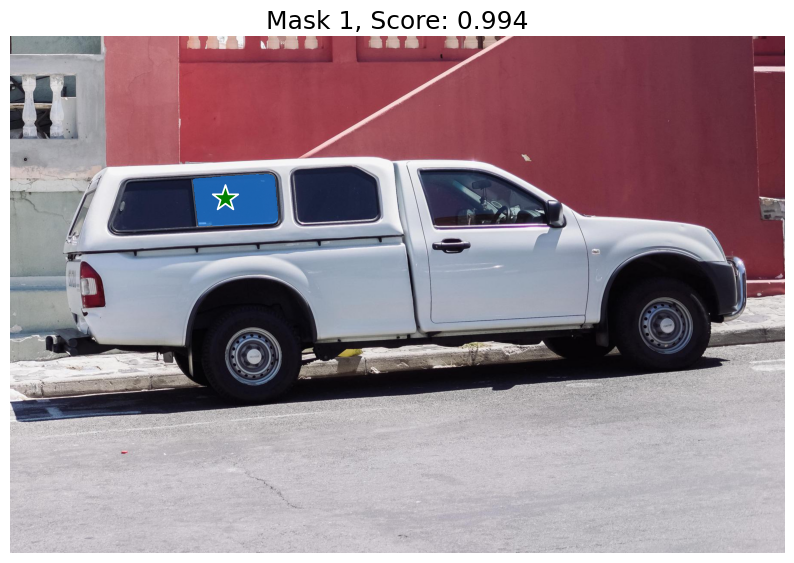

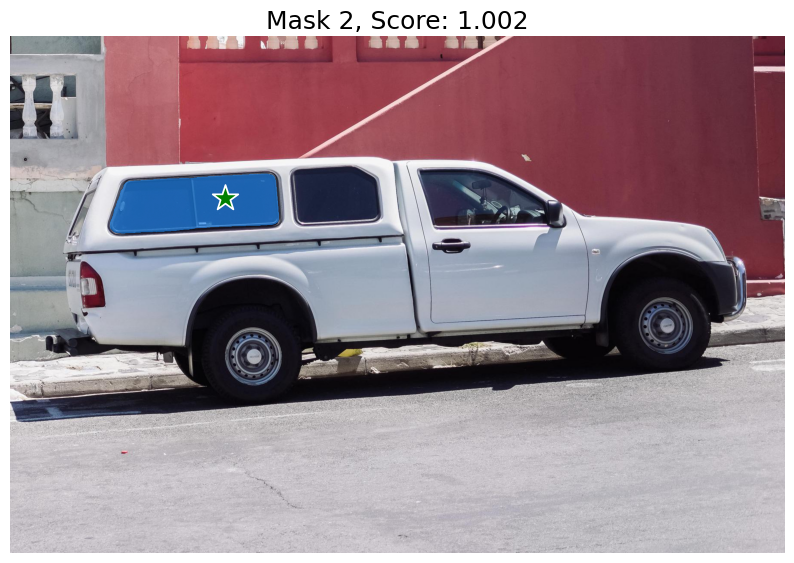

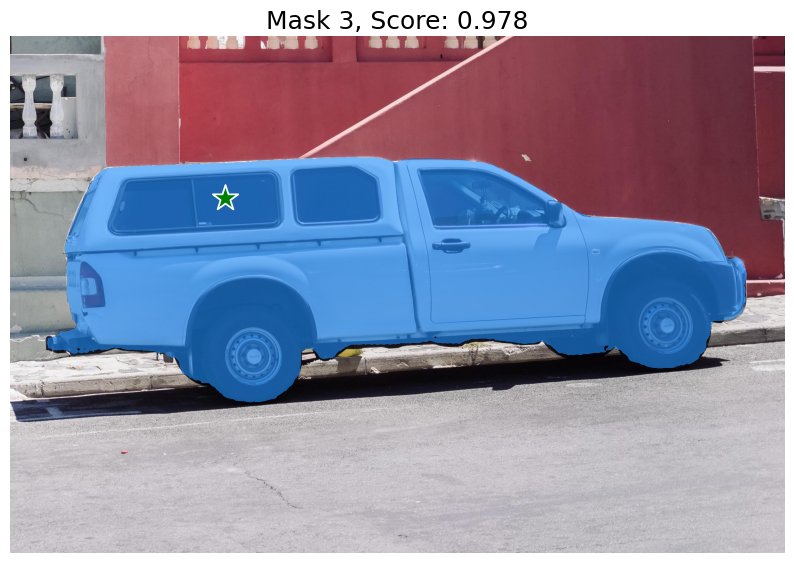

In [66]:
for i, (mask, score) in enumerate(zip(masks, scores)):
  plt.figure(figsize=(10, 10))
  plt.imshow(truck)
  show_mask(mask, plt.gca())
  show_points(input_point, input_label, plt.gca())
  plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
  plt.axis('off')
  plt.show()

### 3. Specifying Objects with Additional Points

In [93]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]

In [96]:
masks, _, _ = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    mask_input = mask_input[None, :, :],
    multimask_output = False
)

(-0.5, 1799.5, 1199.5, -0.5)

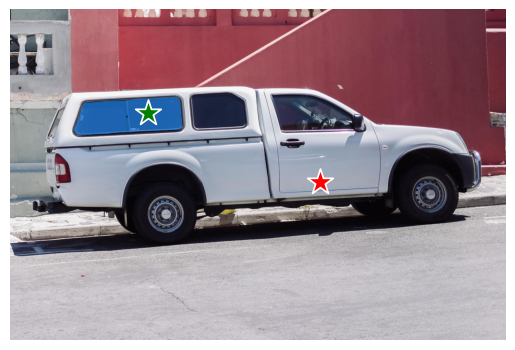

In [97]:
plt.imshow(truck)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')

### 3. Specifying an Object with a Box

In [98]:
# specify a box in the XYXY format
input_box = np.array([425, 600, 700, 875])

In [99]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

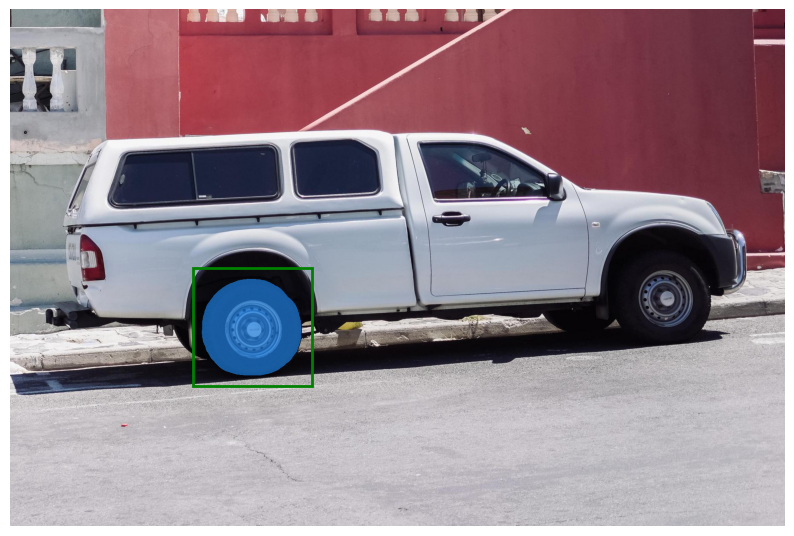

In [101]:
plt.figure(figsize=(10, 10))
plt.imshow(truck)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

### 4. Combining Points and Boxes

In [102]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [103]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

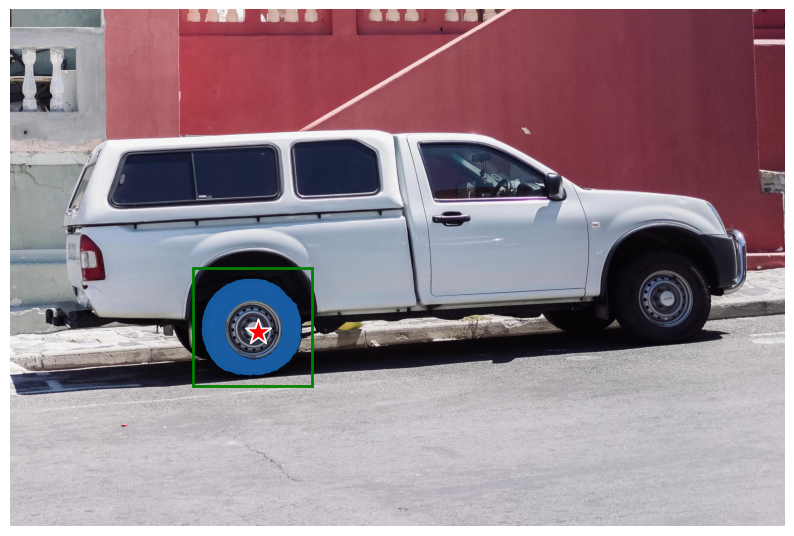

In [104]:
plt.figure(figsize=(10, 10))
plt.imshow(truck)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()